In [11]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from datetime import datetime

In [12]:
#Inputs of the desired data if don't want to change it manually 
input_tickers = ['AMD']
main_ticker = ['AMD'] 
start_date_input = '2016-1-1'
index = '^GSPC'
simulations = 20000
trading_days = 252
rf_rate = 0

In [13]:
#IMPORTING DATA FROM YAHOO FINANCE
def import_stock_data(tickers, start, end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

data = import_stock_data(tickers = main_ticker, start = start_date_input)


/Library/Python/3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'AMD', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


RemoteDataError: No data fetched using 'YahooDailyReader'

In [4]:
#CALCULATING LOG RETURNS 
def log_returns(data):
    return (np.log(1+data.pct_change()))
log_return = log_returns(data)

#CALCULATING SIMPLE RETURNS 
def simple_returns(data):
    return ((data/data.shift(1))-1)
    

In [5]:
#CAPM AND SHARPE
def market_data_combination(data, mark_ticker, start):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return


In [6]:
def beta_sharpe(data, mark_ticker = index, start=start_date_input, riskfree = rf_rate):
    
    """
    Input: 

    riskfree: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    
    Output:
    1. Dataframe with CAPM metrics computed against specified market procy
    """
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*252**0.5)[:-1]), columns=['STD'])

    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={index:"Beta"}, inplace=True)
    
    return beta

capm_sharpe = pd.DataFrame(data = beta_sharpe(data))


In [7]:
#Browinan Motion
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift
drift_calc(data)


array([0.00173349])

In [8]:
#Monte Carlo Returns 
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
    #Oftentimes, we find that the distribution of returns is a variation of the normal distribution where it has a fat tail
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr
dr = daily_returns(data, 2, 3)


/Library/Python/3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Python/3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


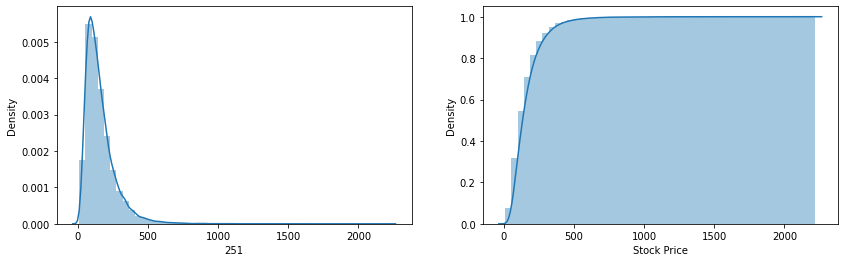

AMD
Days: 251
Expected Value: $159.95
Return: 46.87%
Probability of Breakeven: 0.7589


,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,...,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998,84.974998
1,83.822569,86.510289,81.960869,86.447820,84.513334,87.618517,81.658850,83.521119,84.074058,82.783197,...,86.719601,82.796862,85.876238,80.392014,81.434898,84.481652,87.529745,82.582212,85.296755,88.388436
2,78.750792,80.771007,80.926105,86.074818,78.032287,90.684057,84.793624,84.873973,88.631543,80.901794,...,87.641415,81.876135,93.028080,79.002972,82.269823,85.192567,87.959234,82.120270,87.479641,89.125921
3,81.292623,81.636804,79.032717,85.481375,81.398686,88.921097,85.400568,85.517675,93.710147,80.544089,...,89.047269,79.440919,94.707648,74.768759,80.523109,82.375778,91.006152,79.974235,91.486540,91.650913
4,79.292735,81.238369,82.729162,85.538535,82.399974,86.203586,89.231339,87.017354,91.282329,76.485110,...,86.189560,80.097748,97.692954,77.049368,79.114625,83.477466,88.398906,85.558738,93.514847,97.636462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,120.642583,140.393960,128.663033,63.656954,157.283168,55.881272,324.066648,144.697852,155.268780,101.966968,...,244.355866,120.441618,107.564899,57.346115,122.954721,59.080409,60.868884,49.658600,111.332501,387.291758
248,135.645130,134.341422,127.108979,62.566958,156.562544,54.810084,330.090180,145.344129,150.407036,106.951953,...,230.751643,119.977523,101.070332,60.580402,117.554555,58.887211,61.195853,51.115681,108.634350,399.674473
249,132.668581,139.442316,119.640541,62.361336,159.056148,53.752844,319.994609,157.532248,150.814349,109.262021,...,231.873991,112.505901,103.505111,62.872710,116.460657,57.348876,63.778876,54.047502,105.742177,391.796734
250,128.561172,134.936070,117.163498,62.230133,150.257000,54.514546,329.727642,149.364696,140.480970,108.311263,...,229.982809,109.531979,105.508068,63.692392,115.272977,57.292137,63.440321,53.337656,109.052277,389.750356


In [9]:
def probs_find(predicted, higherthan, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    """
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)
simulate_mc(data, days = trading_days, iterations = simulations, return_type = 'log')


/Library/Python/3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Python/3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


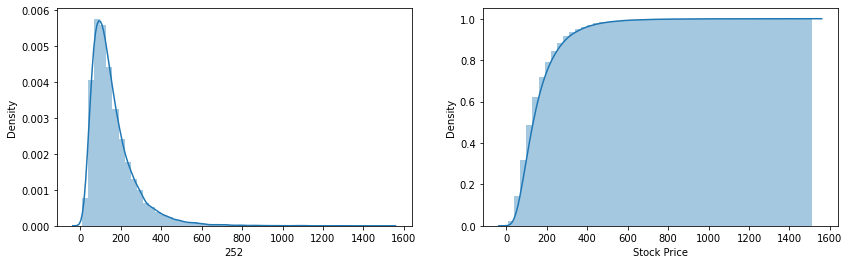

AMD
Days: 252
Expected Value: $160.07
Return: 46.91%
Probability of Breakeven: 0.75815
         Beta       STD      CAPM   Sharpe
AMD  1.501616  0.618885  0.218615  0.35324
Beta: 1.5
Sharpe: 0.35
CAPM Return: 21.86%


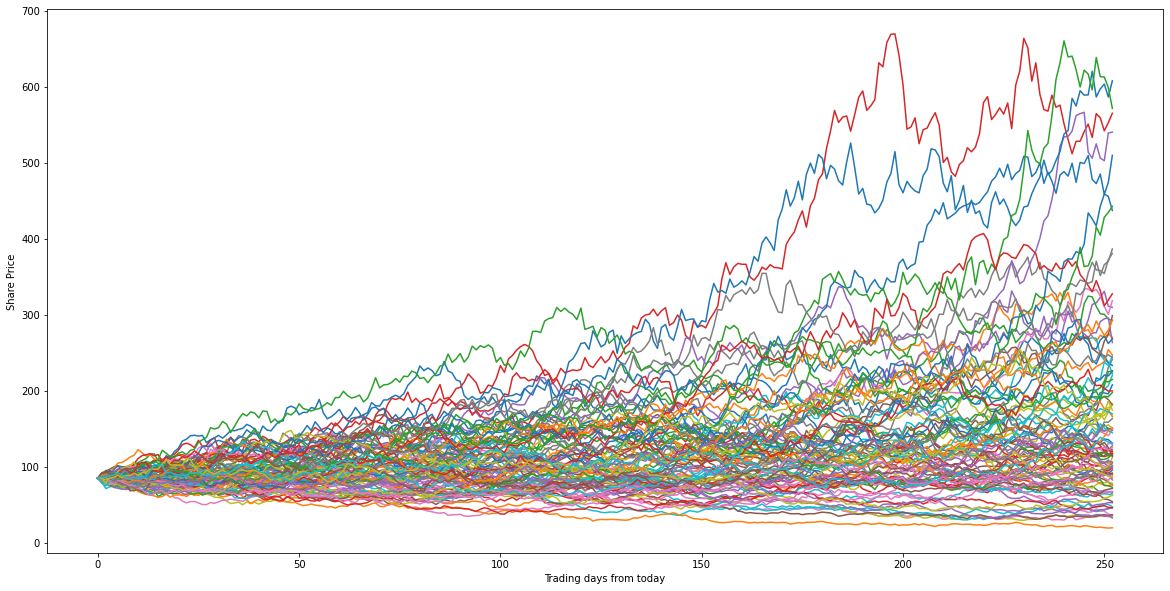

In [10]:
def monte_carlo(tickers, days_forecast, iterations, start_date, return_type = 'log', plotten=True):
    data = import_stock_data(input_tickers, start=start_date_input)
    inform = beta_sharpe(data, mark_ticker=index, start=start_date_input)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations, return_type)
        if plotten == True:
            forplot = y.iloc[:,0:100]
            forplot.plot(figsize=(20,10), legend = None, xlabel = 'Trading days from today', ylabel = 'Share Price')
        print(inform)
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
        simulatedDF = pd.concat(simulatedDF)
    return simulatedDF


ret_sim_df = monte_carlo(input_tickers, days_forecast= trading_days, iterations=simulations,  start_date=start_date_input, plotten=True)

